# First experiments with all LFI data

In [1]:
# Importing all packages
# normalizing flows packages
import torch
from torch.utils.data import TensorDataset, DataLoader
import normflows as nf

# loforest and locart functions
from CP2LFI.loforest import ConformalLoforest, tune_loforest_LFI
from CP2LFI.scores import Scores
from CP2LFI.simulations import Simulations, naive, predict_naive_quantile
from CP2LFI.posterior_models import normflow_posterior

# quantile regression
from sklearn.ensemble import HistGradientBoostingRegressor

# plotting and numpy
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

# package to simulate from weinberg LFI data
# weinberg data (physics)
from hypothesis.benchmark import weinberg
# mg1 data (queue theory)
from hypothesis.benchmark import mg1
# multivariate normal (toy example)
from hypothesis.benchmark import tractable

## Organizing preliminary functions and classes first:

In [31]:
# creating waldo Score using 
class WaldoScore(Scores):
    def fit(self, X = None, thetas = None):
        # setting up model for normalizing flows
        if self.is_fitted:
            return self
        elif self.base_model is not None:
            self.base_model.fit(X, thetas)
        else:
            return self

    def compute(self, thetas, X, N = 10**4):
        # simulating from each theta and dataset to compute waldo statistic
        i = 0
        lambdas = np.zeros(thetas.shape[0])
        
        for theta in tqdm(thetas, desc = "Computing waldo statistics using posterior model"):
            # simulating from the model
            s = self.base_model.sample(X = X[i, :], num_samples = N)
            
            # computing E[theta|X]
            mean_theta_X = np.mean(s, axis = 0)
            var_theta_x = np.cov(s, rowvar = False)

            # computing waldo statistic
            lambdas[i] = (mean_theta_X - theta).transpose() @ np.linalg.inv(var_theta_x) @ (mean_theta_X - theta)
            i += 1

        return lambdas

    def predict(self, thetas, cutoffs):
        # TODO: grid with thetas and cutoffs to generate set
        pass

In [11]:
a = np.array([[1, 2, 4, 5], [4, 5, 6, 7]])
np.mean(a, axis = 0)

array([2.5, 3.5, 5. , 6. ])

## Starting by the multivariate normal data:

Simulating and testing for tractable:

In [3]:
simulator = tractable.Simulator()
prior = tractable.Prior()

Setting $n = 5$ and $B^{'} = 20000$ for posterior modeling:

In [4]:
B_model = 20000
n = 5
torch.manual_seed(45)
# simulating thetas
thetas = prior.sample((B_model, ))
repeated_thetas = thetas.repeat_interleave(repeats = n, dim = 0)

# simulating X's
X_sample = simulator(repeated_thetas)
X_sample

tensor([[-2.9993,  8.6610, -2.1877,  ..., 14.9947, -2.4180,  5.0459],
        [-4.8375, 16.4044, -1.7262,  ...,  3.8428, -1.3336,  0.2528],
        [-2.1486,  4.4116, -1.3949,  ...,  2.8464, -3.0503,  6.7046],
        ...,
        [-3.3671,  3.4088, -2.5926,  ...,  4.1968, -0.7817,  1.2184],
        [-1.8869,  2.7061, -3.4993,  ...,  4.8564, -2.7461,  3.4079],
        [-1.3889,  1.1836, -2.1190,  ...,  1.3677, -1.9069,  0.3168]])

In [5]:
X_dim = X_sample.shape[1]
X_net = X_sample.reshape(B_model, n * X_dim)

In [6]:
X_net.shape

torch.Size([20000, 40])

Fitting normalizing flow model:

In [7]:
nflow_post = normflow_posterior(
    latent_size = thetas.shape[1],
    sample_size = X_net.shape[1], 
    n_flows = 4, 
    hidden_units = 64, 
    hidden_layers = 2,
    enable_cuda = True,
    )

nflow_post.fit(X_net.numpy(), thetas.numpy(), patience = 100, n_epochs = 2000, batch_size = 250)

Fitting normalizing flows posterior estimator: 100%|██████████| 2000/2000 [06:57<00:00,  4.79it/s]

a


normflow_posterior(latent_size=5, sample_size=40)

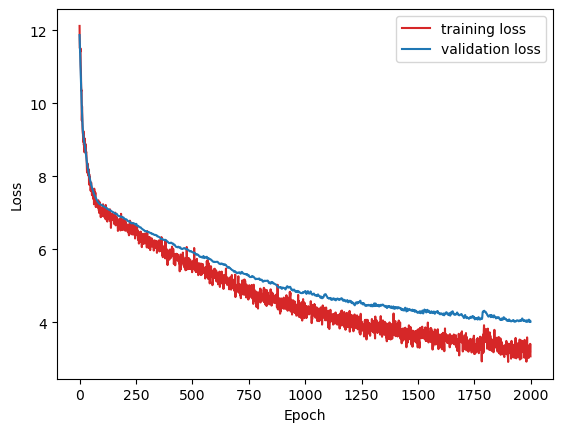

In [8]:
nflow_post.plot_history()

Simulating sample to fit confidence regions estimators:

In [28]:
# simulating to fit estimated confidence regions
B_rand = 10000
n = 5

torch.manual_seed(125)
# sampling from theta
thetas = prior.sample((B_rand, ))
repeated_thetas = thetas.repeat_interleave(repeats = n, dim = 0)
X_conf = simulator(repeated_thetas)
X_dim = X_conf.shape[1]
X_net = X_conf.reshape(B_rand, n * X_dim)

In [32]:
waldo_score = WaldoScore(nflow_post, is_fitted = True)
waldo_score.fit()

In [33]:
sample_waldo = waldo_score.compute(thetas.numpy(), X = X_net.numpy(), N = 1000)

Computing waldo statistics using posterior model: 100%|██████████| 10000/10000 [05:51<00:00, 28.41it/s]


In [35]:
w_simulator = weinberg.Simulator()
w_prior = weinberg.Prior()

thetas = w_prior.sample((10, ))

tensor([0.5678, 0.5230, 0.8048, 1.2320, 0.5509, 0.9219, 1.4526, 0.7062, 0.6981,
        1.4089])

In [21]:
# using waldo score
loforest_object = ConformalLoforest(WaldoScore, base_model = nflow_post, alpha = 0.05, is_fitted = True, split_calib = False)
loforest_object.calibrate(
    thetas.numpy(), 
    X_net.numpy(), 
    min_samples_leaf=300, 
    n_estimators= 200,
    K = 50,
    )

KeyboardInterrupt: 